# Deep Learning - PyTorch

## Importación de librearías 

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
from collections import Counter
from tqdm import tqdm
import random


print(f'Pytorch version: {torch.__version__}')

print(f'Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}')
print(f'Is MPS available? {torch.backends.mps.is_available()}')

Pytorch version: 1.13.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True


## Análisis Exploratorio

### Se revisa la cantidad de imágenes disponibles

In [2]:
base_dir = './catsvsdogs/'
base_dir = Path(base_dir)
img_count = len(list(base_dir.glob('*/*')))
print('Total images: ', img_count)

Total images:  4898


### Se obtiene la información de las extensiones de los archivos y se grafica la información

In [3]:
def get_file_info(dir):
  ext = []
  
  for i in os.listdir(dir):
    file_name, file_ext = os.path.splitext(i)
    if not file_name.startswith('.'):
      ext.append(file_ext)

  return Counter(ext)

cats_dir = './catsvsdogs/cats/'
dogs_dir = './catsvsdogs/dogs/'

cats_ext = get_file_info(cats_dir)
dogs_ext = get_file_info(dogs_dir)

print(cats_ext)

Counter({'.jpg': 2400, '.mat': 3})


In [4]:
def create_df(name_ext):
  df_ext = pd.DataFrame.from_dict(name_ext, orient='index').reset_index().rename(columns={'index':'file_type', 0:'count'})

  return df_ext

cats_ext_df = create_df(cats_ext)
dogs_ext_df = create_df(dogs_ext)

<AxesSubplot: title={'center': 'Dogs File Extensions'}, xlabel='file_type'>

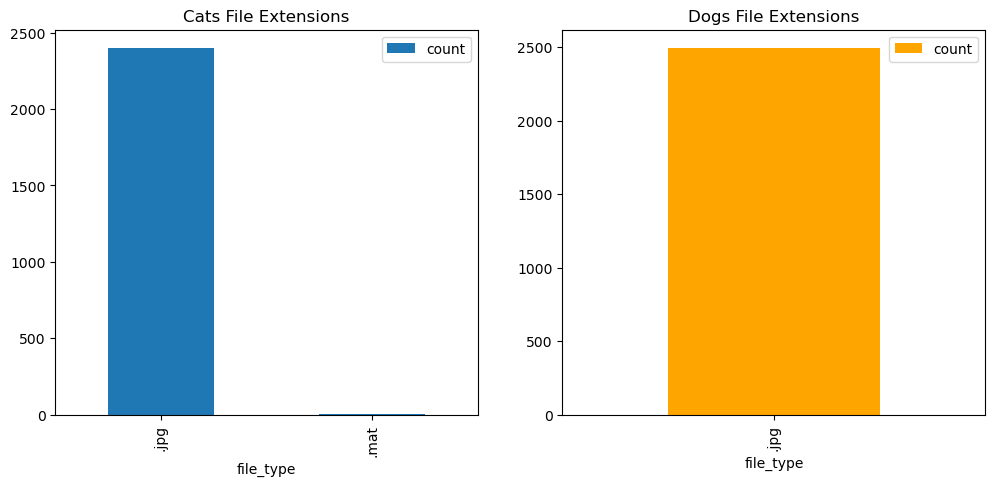

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

cats_ext_df.sort_values(by='count', ascending=False).plot.bar(x='file_type', y='count', ax=axs[0], title='Cats File Extensions')      
dogs_ext_df.sort_values(by='count', ascending=False).plot.bar(x='file_type', y='count', ax=axs[1], title='Dogs File Extensions', color='orange')

#### Se observa que hay unos archivos en extensión *.mat. Dado que no es una extensión de imagen, se ignorará en los siguientes procesos

### Se revisan los tamaños/resoluciones de las imágenes proporcionadas

In [6]:
def get_file_size(dir):
  
  img_size = []
  for i in os.listdir(dir):
    file_name, file_ext = os.path.splitext(i)
    if not file_ext == '.mat':
      if not file_name.startswith('.'):
        img = Image.open(dir+i)
        img_width, img_height = img.size
        size = str(img_width)+'x'+str(img_height)
        img_size.append(size)
        img.close()

  return Counter(img_size)

cats_size = get_file_size(cats_dir)
dogs_size = get_file_size(dogs_dir)


In [7]:
cats_size_df = create_df(cats_size)
dogs_size_df = create_df(dogs_size)

In [8]:
cats_size_df['percentage'] = ((cats_size_df['count']/(cats_size_df['count'].sum())*100))
dogs_size_df['percentage'] = ((dogs_size_df['count']/(dogs_size_df['count'].sum())*100))

Text(0.5, 0, 'image resolutions')

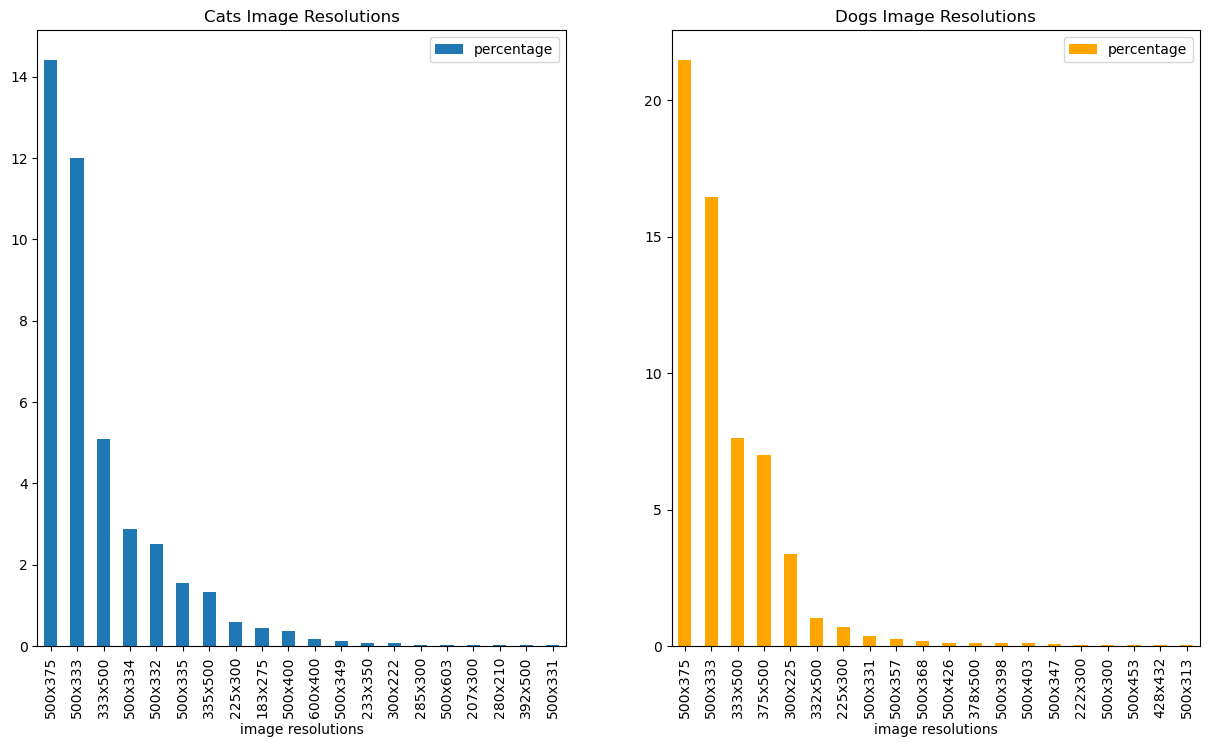

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

cats_size_df.head(20).sort_values(by='percentage', ascending=False).plot.bar(x='file_type', y='percentage', ax=axs[0], title='Cats Image Resolutions')
axs[0].set_xlabel('image resolutions')      
dogs_size_df.head(20).sort_values(by='percentage', ascending=False).plot.bar(x='file_type', y='percentage', ax=axs[1], title='Dogs Image Resolutions', color='orange')
axs[1].set_xlabel('image resolutions')

#### Se observa que se tienen muchísimos formatos de imágen, ya que en el gráfico solo se muestra el top 20 en porcentajes

### Para evitar problemas en la fase de entrenamiento, se escribe un loop para eliminar los archivos que no sean jpg

In [10]:

for i in tqdm(os.listdir(cats_dir), colour='green'):
  file_name, file_ext = os.path.splitext(i)
  if not file_ext == '.jpg':
    os.remove(cats_dir+i)
    print('Removed file: ', i)

for i in tqdm(os.listdir(dogs_dir), colour='green'):
  file_name, file_ext = os.path.splitext(i)
  if not file_ext == '.jpg':
    os.remove(dogs_dir+i)
    print('Removed file: ', i)

100%|██████████| 2403/2403 [00:00<00:00, 584250.91it/s]


Removed file:  Abyssinian_102.mat
Removed file:  Abyssinian_100.mat
Removed file:  Abyssinian_101.mat


100%|██████████| 2495/2495 [00:00<00:00, 757220.58it/s]


### Se visualizan algunas imágenes

Path:  catsvsdogs/dogs/american_bulldog_112.jpg
Class:  dogs
Width: 500 | Height: 500


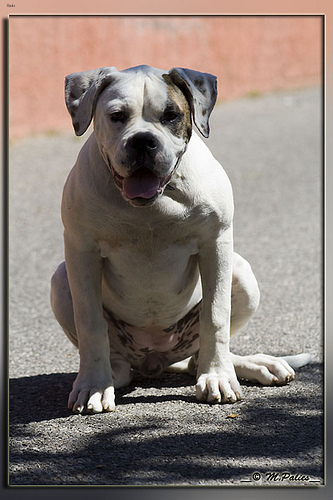

In [11]:


rnd_img_path = random.choice(list(base_dir.glob('*/*')))
img_class = rnd_img_path.parent.stem

img = Image.open(rnd_img_path)


print('Path: ', rnd_img_path)
print('Class: ', img_class)
print(f'Width: {img.height} | Height: {img.height}')
img



Path:  catsvsdogs/dogs/pomeranian_113.jpg
Class:  dogs
Width: 225 | Height: 225


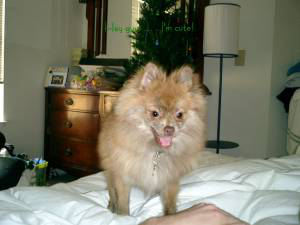

In [12]:
rnd_img_path = random.choice(list(base_dir.glob('*/*')))
img_class = rnd_img_path.parent.stem

img = Image.open(rnd_img_path)


print('Path: ', rnd_img_path)
print('Class: ', img_class)
print(f'Width: {img.height} | Height: {img.height}')
img


Path:  catsvsdogs/cats/Sphynx_85.jpg
Class:  cats
Width: 500 | Height: 500


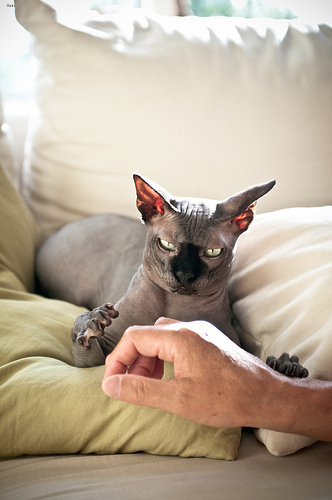

In [13]:
rnd_img_path = random.choice(list(base_dir.glob('*/*')))
img_class = rnd_img_path.parent.stem

img = Image.open(rnd_img_path)


print('Path: ', rnd_img_path)
print('Class: ', img_class)
print(f'Width: {img.height} | Height: {img.height}')
img


Path:  catsvsdogs/cats/Russian_Blue_179.jpg
Class:  cats
Width: 332 | Height: 332


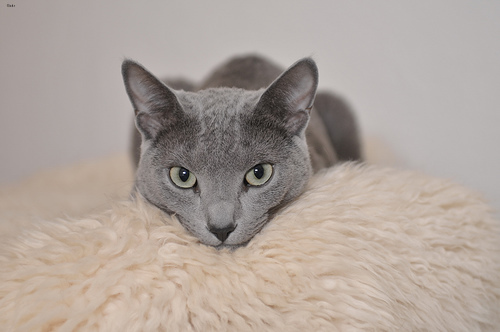

In [14]:
rnd_img_path = random.choice(list(base_dir.glob('*/*')))
img_class = rnd_img_path.parent.stem

img = Image.open(rnd_img_path)


print('Path: ', rnd_img_path)
print('Class: ', img_class)
print(f'Width: {img.height} | Height: {img.height}')
img


Path:  catsvsdogs/cats/Bengal_177.jpg
Class:  cats
Width: 300 | Height: 300


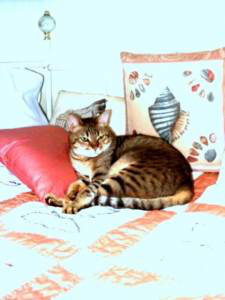

In [15]:
rnd_img_path = random.choice(list(base_dir.glob('*/*')))
img_class = rnd_img_path.parent.stem

img = Image.open(rnd_img_path)


print('Path: ', rnd_img_path)
print('Class: ', img_class)
print(f'Width: {img.height} | Height: {img.height}')
img


#### Se observa que, en efecto, las imágenes vienen dadas en varios tamaños

## Creación de DataSet

### Se divide el directorio original para crear folders de train, val y test

In [27]:
import splitfolders
os.makedirs('./images/')

In [28]:
splitfolders.ratio(
   './catsvsdogs/',
   output='./images/',
   seed=16,
   ratio=(0.85, 0.10, 0.05),
   move=False
 )

Copying files: 4895 files [00:02, 1992.77 files/s]


### Se crean los sets de entrenamiento, validación y prueba

In [3]:
img_size = 240

data_transform = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.ToTensor()
])

data_augmentation = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.RandomVerticalFlip(p=0.7),
  transforms.RandomHorizontalFlip(p=0.7),
  transforms.RandomRotation(degrees=(0, 90)),
  transforms.ToTensor()

])


In [4]:
train_dir = './images/train/'
val_dir = './images/val/'
test_dir = './images/test/'

train_data = datasets.ImageFolder(root=train_dir, transform=data_augmentation)
val_data = datasets.ImageFolder(root=val_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f'Train data:\n{train_data}\nVal data:\n{val_data}\nTest data:\n{test_data}')

Train data:
Dataset ImageFolder
    Number of datapoints: 24960
    Root location: ./images/train/
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               RandomVerticalFlip(p=0.7)
               RandomHorizontalFlip(p=0.7)
               RandomRotation(degrees=[0.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
Val data:
Dataset ImageFolder
    Number of datapoints: 489
    Root location: ./images/val/
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 246
    Root location: ./images/test/
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


### Se valida que la instrucción de ImageFolder se haya ejecutado correctamente

In [4]:
class_names = train_data.classes
print(class_names)

['cats', 'dogs']


In [5]:
class_dict = train_data.class_to_idx
print(class_dict)

{'cats': 0, 'dogs': 1}


In [6]:
len(train_data), len(val_data), len(test_data)

(24960, 489, 246)

In [7]:
img, lab = train_data[0][0], train_data[0][1]

print('Image shape: ', img.shape)
print('Image datatype: ', img.dtype)
print('Image label: ', lab, class_names[lab])
print('Label datatype: ', type(lab))

Image shape:  torch.Size([3, 240, 240])
Image datatype:  torch.float32
Image label:  0 cats
Label datatype:  <class 'int'>


### Se muestra una imagen del set de entrenamiento, validación y prueba

Orig shape:  torch.Size([3, 240, 240]) [color channels, height, width]
Permute shape:  torch.Size([240, 240, 3]) [height, width, color channels


Text(0.5, 1.0, 'cats')

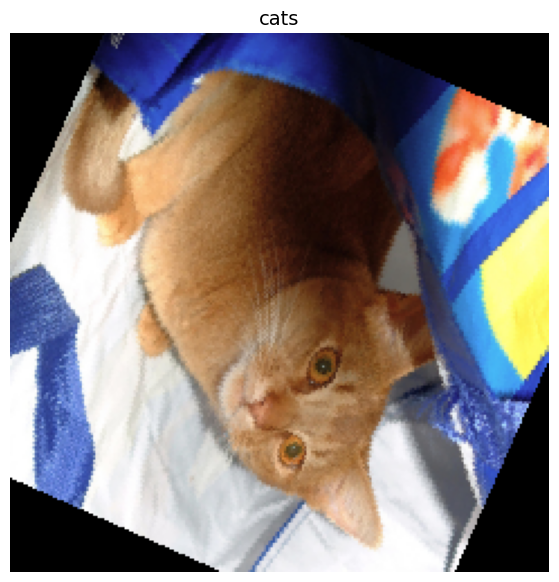

In [15]:
### Imagen set de prueba

img_permute = img.permute(1, 2, 0)

print('Orig shape: ', img.shape, '[color channels, height, width]')
print('Permute shape: ', img_permute.shape, '[height, width, color channels')

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[lab], fontsize=14)

Orig shape:  torch.Size([3, 240, 240]) [color channels, height, width]
Permute shape:  torch.Size([240, 240, 3]) [height, width, color channels


Text(0.5, 1.0, 'cats')

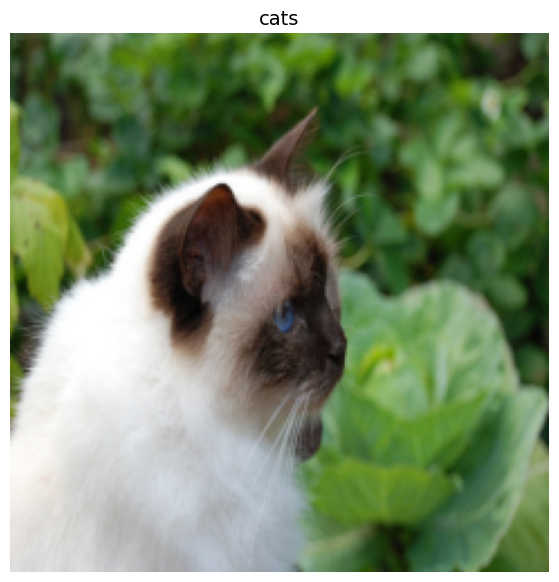

In [16]:
### Imagen set de validación

img_val, lab_val = val_data[50][0], val_data[50][1]

img_val_permute = img_val.permute(1, 2, 0)

print('Orig shape: ', img_val.shape, '[color channels, height, width]')
print('Permute shape: ', img_val_permute.shape, '[height, width, color channels')

plt.figure(figsize=(10,7))
plt.imshow(img_val_permute)
plt.axis('off')
plt.title(class_names[lab_val], fontsize=14)

Orig shape:  torch.Size([3, 240, 240]) [color channels, height, width]
Permute shape:  torch.Size([240, 240, 3]) [height, width, color channels


Text(0.5, 1.0, 'dogs')

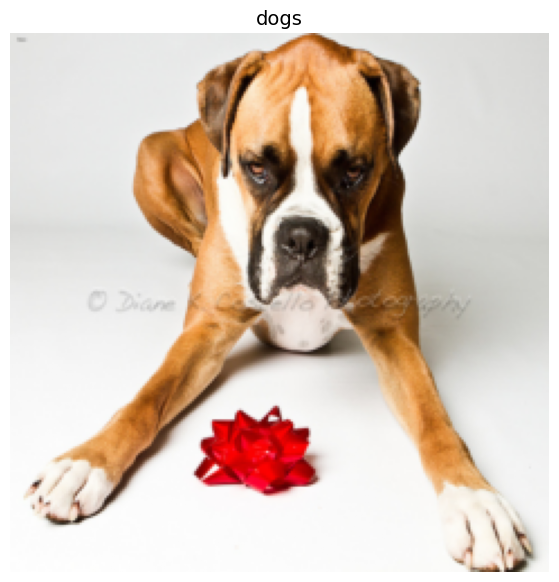

In [17]:
### Imagen test de prueba

img_test, lab_test = test_data[150][0], test_data[150][1]

img_test_permute = img_test.permute(1, 2, 0)

print('Orig shape: ', img_test.shape, '[color channels, height, width]')
print('Permute shape: ', img_test_permute.shape, '[height, width, color channels')

plt.figure(figsize=(10,7))
plt.imshow(img_test_permute)
plt.axis('off')
plt.title(class_names[lab_test], fontsize=14)

### Se crea el objeto de DataLoader para el modelo de PyTorch

In [7]:
train_dataload = DataLoader(
  dataset=train_data,
  batch_size=64,
  num_workers=os.cpu_count(),
  shuffle=True
)

val_dataload = DataLoader(
  dataset=val_data,
  batch_size=64,
  num_workers=os.cpu_count(),
  shuffle=False
)

test_dataload = DataLoader(
  dataset=test_data,
  batch_size=64,
  num_workers=os.cpu_count(),
  shuffle=False
)

train_dataload, val_dataload, test_dataload

(<torch.utils.data.dataloader.DataLoader at 0x110930220>,
 <torch.utils.data.dataloader.DataLoader at 0x110930f70>)

In [9]:
img, label = next(iter(train_dataload))

print(img.shape)
print(label.shape)

torch.Size([64, 3, 240, 240])
torch.Size([64])


## Creación del primer modelo de entrenamiento

### Se define el modelo y el dispositivo de entrenamiento

In [8]:
device = torch.device('mps')
print(f'Using device: {device}')


Using device: mps


In [11]:
class MyModel_1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_shape, 
        out_channels=hidden_units, 
        kernel_size=3,
        stride=1,
        padding=1
      ), 
      nn.ReLU(),
      nn.BatchNorm2d(
        num_features=hidden_units
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      ) 
    )
  
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units, 
        out_channels=hidden_units*2,
        kernel_size=3,
        stride=1,
        padding=1
      ), 
      nn.ReLU(),
      nn.BatchNorm2d(
        num_features=hidden_units*2
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )

    self.conv_block_3 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units*2, 
        out_channels=hidden_units*4,
        kernel_size=3,
        stride=1,
        padding=1
      ),
      nn.ReLU(),
      nn.BatchNorm2d(
        num_features=hidden_units*4
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )

    self.classifier = nn.Sequential(
      nn.Flatten(), 
      nn.Linear(
        in_features=hidden_units*4*30*30,
        out_features=12
      ),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(
        in_features=12,
        out_features=6
      ),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(
        in_features=6,
        out_features=output_shape
      )
    )

  def forward(self, x):
    
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))
    

    
    

### Se hace una compilación del modelo para ver que se haya creado correctamente

In [12]:
model_1 = MyModel_1(input_shape=3, hidden_units=16, output_shape=len(train_data.classes)).to(device)

model_1

MyModel_1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_feature

### Se utiliza la librería torchinfo para obtener un resumen del modelo y validar que el modelo funciona como se espera

In [13]:
summary(model_1, input_size=[64, 3, 240, 240])

Layer (type:depth-idx)                   Output Shape              Param #
MyModel_1                                [64, 2]                   --
├─Sequential: 1-1                        [64, 16, 120, 120]        --
│    └─Conv2d: 2-1                       [64, 16, 240, 240]        448
│    └─ReLU: 2-2                         [64, 16, 240, 240]        --
│    └─BatchNorm2d: 2-3                  [64, 16, 240, 240]        32
│    └─MaxPool2d: 2-4                    [64, 16, 120, 120]        --
├─Sequential: 1-2                        [64, 32, 60, 60]          --
│    └─Conv2d: 2-5                       [64, 32, 120, 120]        4,640
│    └─ReLU: 2-6                         [64, 32, 120, 120]        --
│    └─BatchNorm2d: 2-7                  [64, 32, 120, 120]        64
│    └─MaxPool2d: 2-8                    [64, 32, 60, 60]          --
├─Sequential: 1-3                        [64, 64, 30, 30]          --
│    └─Conv2d: 2-9                       [64, 64, 60, 60]          18,496
│    └─

### Se crean las funciones de entrenamiento y prueba

In [12]:
def train_steps(model, dataloader, loss_fn, optimiser):
  model.train() # Entrenamiento del modelo
  train_loss, train_acc = 0, 0 # Valores de inicio para pérdidas

  for batch, (X, y) in enumerate(dataloader): # Loop para pasar por los datos de entrenamiento
    X, y = X.to(device), y.to(device) # Se pasan los datos al dispositivo establecido anteriormente
    y_pred = model(X) # Se hace la pasada hacia adelante
    loss = loss_fn(y_pred, y) # Se calculan las pérdidas
    train_loss += loss.item() # Se acumulan las pérdidas

    optimiser.zero_grad() # Se establece el gradiente en cero
    loss.backward() # Se hace el 'retroceso' del gradiente

    optimiser.step() 

    # Se calcula y acumulan las métricas de precisión de todos los batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Ajuste a las métricas para obtener promedios
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [13]:
def test_steps(model, dataloader, loss_fn, scheduler=None):
  model.eval() # Se pone al modelo en modo de evaluación

  test_loss, test_acc = 0, 0

  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_preds_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_preds_labels == y).sum().item()/len(test_preds_labels))

  if scheduler==None:
    pass
  else:
    scheduler.step(test_loss)


  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

In [14]:

def train(model, train_dataloader, test_dataloader, optimiser, scheduler, loss_fn, epochs=5):
  # Diccionario para guardar los resultados
  results = {
    'train_loss':[],
    'train_acc':[],
    'test_loss':[],
    'test_acc':[]
  }

  # Loop de entrenamiento y prueba
  for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = train_steps(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimiser=optimiser)
    test_loss, test_acc = test_steps(model=model, dataloader=test_dataloader, loss_fn=loss_fn, scheduler=scheduler)

    print(f'Epoch {epoch+1}\n -------- \n') 
    print(f'train loss: {train_loss:0.5f}, train accuracy: {train_acc:0.5f} | test_loss: {test_loss:0.5f}, test accuracy: {test_acc:0.5f}')

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)




  return results


### Primera prueba del modelo

In [28]:
num_epochs = 50

model_1 = MyModel_1(input_shape=3, hidden_units=32, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
lr_rate = 5e-4
optimiser = torch.optim.SGD(params=model_1.parameters(), lr=lr_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=0, threshold=1e-5, threshold_mode='abs', verbose=1)

model_1_results = train(
  model=model_1,
  train_dataloader=train_dataload,
  test_dataloader=val_dataload,
  optimiser=optimiser,
  scheduler=scheduler,
  loss_fn=loss_fn,
  epochs=num_epochs)

print('Train Finished')


  2%|▏         | 1/50 [01:52<1:31:38, 112.21s/it]

Epoch 1
 -------- 

train loss: 0.69431, train accuracy: 0.51034 | test_loss: 0.69010, test accuracy: 0.55640


  4%|▍         | 2/50 [03:43<1:29:14, 111.55s/it]

Epoch 2
 -------- 

train loss: 0.69115, train accuracy: 0.51851 | test_loss: 0.68643, test accuracy: 0.54078


  6%|▌         | 3/50 [05:34<1:27:14, 111.38s/it]

Epoch 3
 -------- 

train loss: 0.68950, train accuracy: 0.52668 | test_loss: 0.68307, test accuracy: 0.54664


  8%|▊         | 4/50 [07:25<1:25:22, 111.37s/it]

Epoch 4
 -------- 

train loss: 0.68492, train accuracy: 0.53918 | test_loss: 0.68058, test accuracy: 0.56617


 10%|█         | 5/50 [09:16<1:23:28, 111.29s/it]

Epoch 5
 -------- 

train loss: 0.68443, train accuracy: 0.54351 | test_loss: 0.67853, test accuracy: 0.58741


 12%|█▏        | 6/50 [11:08<1:21:40, 111.38s/it]

Epoch 6
 -------- 

train loss: 0.68216, train accuracy: 0.54135 | test_loss: 0.67565, test accuracy: 0.63467


 14%|█▍        | 7/50 [12:59<1:19:46, 111.32s/it]

Epoch 7
 -------- 

train loss: 0.68241, train accuracy: 0.55288 | test_loss: 0.67063, test accuracy: 0.65030


 16%|█▌        | 8/50 [14:51<1:18:00, 111.43s/it]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.
Epoch 8
 -------- 

train loss: 0.68007, train accuracy: 0.55048 | test_loss: 0.67101, test accuracy: 0.62881


 18%|█▊        | 9/50 [16:42<1:16:05, 111.36s/it]

Epoch 9
 -------- 

train loss: 0.67977, train accuracy: 0.55072 | test_loss: 0.67035, test accuracy: 0.64053


 20%|██        | 10/50 [18:33<1:14:13, 111.33s/it]

Epoch 10
 -------- 

train loss: 0.67914, train accuracy: 0.55240 | test_loss: 0.66999, test accuracy: 0.65615


 22%|██▏       | 11/50 [20:24<1:12:17, 111.22s/it]

Epoch 11
 -------- 

train loss: 0.67674, train accuracy: 0.56514 | test_loss: 0.66942, test accuracy: 0.65701


 24%|██▍       | 12/50 [22:15<1:10:24, 111.17s/it]

Epoch 12
 -------- 

train loss: 0.67737, train accuracy: 0.55144 | test_loss: 0.66924, test accuracy: 0.64444


 26%|██▌       | 13/50 [24:07<1:08:33, 111.17s/it]

Epoch 13
 -------- 

train loss: 0.67721, train accuracy: 0.55841 | test_loss: 0.66862, test accuracy: 0.65811


 28%|██▊       | 14/50 [25:58<1:06:40, 111.13s/it]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-06.
Epoch 14
 -------- 

train loss: 0.67699, train accuracy: 0.56178 | test_loss: 0.66870, test accuracy: 0.65030


 30%|███       | 15/50 [27:49<1:04:47, 111.08s/it]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-07.
Epoch 15
 -------- 

train loss: 0.67665, train accuracy: 0.56322 | test_loss: 0.66880, test accuracy: 0.65615


 32%|███▏      | 16/50 [29:40<1:03:04, 111.30s/it]

Epoch 16
 -------- 

train loss: 0.67032, train accuracy: 0.56827 | test_loss: 0.66846, test accuracy: 0.65920


 34%|███▍      | 17/50 [31:32<1:01:11, 111.25s/it]

Epoch 00017: reducing learning rate of group 0 to 5.0000e-08.
Epoch 17
 -------- 

train loss: 0.67874, train accuracy: 0.55986 | test_loss: 0.66862, test accuracy: 0.65225


 36%|███▌      | 18/50 [33:23<59:18, 111.21s/it]  

Epoch 00018: reducing learning rate of group 0 to 5.0000e-09.
Epoch 18
 -------- 

train loss: 0.67499, train accuracy: 0.57212 | test_loss: 0.66864, test accuracy: 0.65615


 38%|███▊      | 19/50 [35:14<57:26, 111.18s/it]

Epoch 19
 -------- 

train loss: 0.67711, train accuracy: 0.55409 | test_loss: 0.66870, test accuracy: 0.65615


 40%|████      | 20/50 [37:05<55:37, 111.24s/it]

Epoch 20
 -------- 

train loss: 0.67503, train accuracy: 0.55841 | test_loss: 0.66819, test accuracy: 0.66311


 42%|████▏     | 21/50 [38:56<53:45, 111.22s/it]

Epoch 21
 -------- 

train loss: 0.67642, train accuracy: 0.56106 | test_loss: 0.66828, test accuracy: 0.66116


 44%|████▍     | 22/50 [40:47<51:52, 111.17s/it]

Epoch 22
 -------- 

train loss: 0.67267, train accuracy: 0.57236 | test_loss: 0.66838, test accuracy: 0.65420


 46%|████▌     | 23/50 [42:38<50:00, 111.14s/it]

Epoch 23
 -------- 

train loss: 0.67553, train accuracy: 0.57115 | test_loss: 0.66819, test accuracy: 0.65920


 48%|████▊     | 24/50 [44:30<48:11, 111.21s/it]

Epoch 24
 -------- 

train loss: 0.67375, train accuracy: 0.57548 | test_loss: 0.66887, test accuracy: 0.66006


 50%|█████     | 25/50 [46:21<46:20, 111.24s/it]

Epoch 25
 -------- 

train loss: 0.67427, train accuracy: 0.55721 | test_loss: 0.66825, test accuracy: 0.65334


 52%|█████▏    | 26/50 [48:12<44:29, 111.23s/it]

Epoch 26
 -------- 

train loss: 0.67447, train accuracy: 0.56250 | test_loss: 0.66841, test accuracy: 0.65420


 54%|█████▍    | 27/50 [50:03<42:36, 111.17s/it]

Epoch 27
 -------- 

train loss: 0.67591, train accuracy: 0.55697 | test_loss: 0.66872, test accuracy: 0.65615


 56%|█████▌    | 28/50 [51:54<40:45, 111.14s/it]

Epoch 28
 -------- 

train loss: 0.67446, train accuracy: 0.56635 | test_loss: 0.66800, test accuracy: 0.64748


 58%|█████▊    | 29/50 [53:46<38:57, 111.31s/it]

Epoch 29
 -------- 

train loss: 0.67479, train accuracy: 0.55553 | test_loss: 0.66830, test accuracy: 0.64944


 60%|██████    | 30/50 [55:37<37:05, 111.28s/it]

Epoch 30
 -------- 

train loss: 0.67281, train accuracy: 0.56538 | test_loss: 0.66869, test accuracy: 0.65420


 62%|██████▏   | 31/50 [57:29<35:18, 111.50s/it]

Epoch 31
 -------- 

train loss: 0.67832, train accuracy: 0.55601 | test_loss: 0.66837, test accuracy: 0.65920


 64%|██████▍   | 32/50 [59:22<33:31, 111.75s/it]

Epoch 32
 -------- 

train loss: 0.67355, train accuracy: 0.56442 | test_loss: 0.66861, test accuracy: 0.65225


 66%|██████▌   | 33/50 [1:01:14<31:41, 111.85s/it]

Epoch 33
 -------- 

train loss: 0.68099, train accuracy: 0.54832 | test_loss: 0.66865, test accuracy: 0.65811


 68%|██████▊   | 34/50 [1:03:05<29:48, 111.75s/it]

Epoch 34
 -------- 

train loss: 0.67374, train accuracy: 0.57043 | test_loss: 0.66874, test accuracy: 0.65615


 70%|███████   | 35/50 [1:04:57<27:57, 111.85s/it]

Epoch 35
 -------- 

train loss: 0.67542, train accuracy: 0.56995 | test_loss: 0.66831, test accuracy: 0.65920


 72%|███████▏  | 36/50 [1:06:50<26:09, 112.11s/it]

Epoch 36
 -------- 

train loss: 0.67618, train accuracy: 0.55673 | test_loss: 0.66849, test accuracy: 0.66116


 74%|███████▍  | 37/50 [1:08:43<24:18, 112.21s/it]

Epoch 37
 -------- 

train loss: 0.67707, train accuracy: 0.56322 | test_loss: 0.66883, test accuracy: 0.66006


 76%|███████▌  | 38/50 [1:10:34<22:23, 111.92s/it]

Epoch 38
 -------- 

train loss: 0.67554, train accuracy: 0.56178 | test_loss: 0.66822, test accuracy: 0.65334


 78%|███████▊  | 39/50 [1:12:25<20:29, 111.74s/it]

Epoch 39
 -------- 

train loss: 0.67603, train accuracy: 0.57163 | test_loss: 0.66843, test accuracy: 0.65615


 80%|████████  | 40/50 [1:14:16<18:36, 111.61s/it]

Epoch 40
 -------- 

train loss: 0.67746, train accuracy: 0.55312 | test_loss: 0.66838, test accuracy: 0.65530


 82%|████████▏ | 41/50 [1:16:08<16:43, 111.53s/it]

Epoch 41
 -------- 

train loss: 0.67591, train accuracy: 0.55264 | test_loss: 0.66832, test accuracy: 0.66116


 84%|████████▍ | 42/50 [1:17:59<14:52, 111.53s/it]

Epoch 42
 -------- 

train loss: 0.67618, train accuracy: 0.55457 | test_loss: 0.66843, test accuracy: 0.66116


 86%|████████▌ | 43/50 [1:19:50<12:59, 111.39s/it]

Epoch 43
 -------- 

train loss: 0.67574, train accuracy: 0.55962 | test_loss: 0.66828, test accuracy: 0.65334


 88%|████████▊ | 44/50 [1:21:43<11:09, 111.66s/it]

Epoch 44
 -------- 

train loss: 0.67337, train accuracy: 0.55769 | test_loss: 0.66830, test accuracy: 0.65334


 90%|█████████ | 45/50 [1:23:35<09:19, 111.83s/it]

Epoch 45
 -------- 

train loss: 0.67577, train accuracy: 0.56370 | test_loss: 0.66851, test accuracy: 0.65725


 92%|█████████▏| 46/50 [1:25:26<07:26, 111.67s/it]

Epoch 46
 -------- 

train loss: 0.67623, train accuracy: 0.55817 | test_loss: 0.66853, test accuracy: 0.66116


 94%|█████████▍| 47/50 [1:27:17<05:34, 111.56s/it]

Epoch 47
 -------- 

train loss: 0.67675, train accuracy: 0.55889 | test_loss: 0.66839, test accuracy: 0.66116


 96%|█████████▌| 48/50 [1:29:09<03:43, 111.57s/it]

Epoch 48
 -------- 

train loss: 0.67584, train accuracy: 0.56707 | test_loss: 0.66842, test accuracy: 0.65530


 98%|█████████▊| 49/50 [1:31:01<01:51, 111.82s/it]

Epoch 49
 -------- 

train loss: 0.66936, train accuracy: 0.56322 | test_loss: 0.66856, test accuracy: 0.65420


100%|██████████| 50/50 [1:32:53<00:00, 111.48s/it]

Epoch 50
 -------- 

train loss: 0.67612, train accuracy: 0.55601 | test_loss: 0.66820, test accuracy: 0.65530
Train Finished


In [29]:
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [16]:
def plot_curves(results):
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(12,5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train loss')
  plt.plot(epochs, test_loss, label='val loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train accuracy')
  plt.plot(epochs, test_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

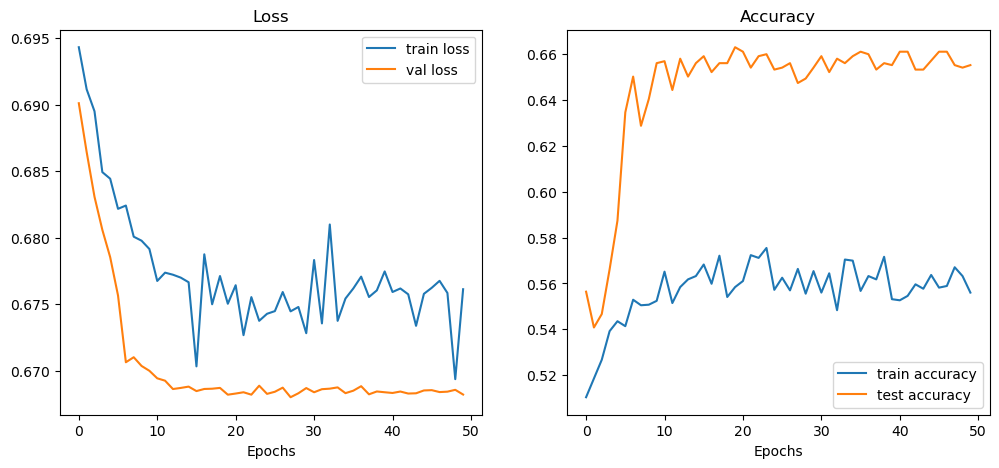

In [32]:
plot_curves(model_1_results)

#### Se observa que el modelo no tiene un comportamiento lineal ni en las pérdidas ni en la precisión. Se intentará aumentar el tamaño del set de entrenamiento, ya que ni con las transformaciones hechas en PyTorch el ajuste fue suficiente

In [29]:
from PIL import ImageEnhance, ImageFilter
import random

train_cats_dir = './images/train/cats/'
train_dogs_dir = './images/train/dogs/'

def augment_images(dir):
  
  rnd_float = random.uniform(0.1, 0.5)
  rnd_int = random.randint(30,80)
  rnd_int_min = random.uniform(0.6, 1.1)
  

  for file in tqdm(os.listdir(dir), colour='magenta'):
    try:
      if not file.startswith('.'):
          img = Image.open(dir+file)
          if img.mode!='RGB':
            img = img.convert('RGB')
          
          blur = img.filter(ImageFilter.BLUR)
          blur.save(dir+'blur_'+file)
          blur.close()
          
          flip_v = img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
          flip_v.save(dir+'flip_v_'+file)
          flip_v.close()
          
          flip_h = img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
          flip_h.save(dir+'flip_h'+file)
          flip_h.close()

          rot = img.rotate(angle=rnd_int)
          rot.save(dir+'rot_'+file)
          rot.close()

          brightner = ImageEnhance.Brightness(img)
          bright = brightner.enhance(factor=rnd_int_min+rnd_float)
          bright.save(dir+'bright_'+file)
          bright.close()

          img.close()
    except RuntimeError:
      print('Broken file: ', file)

In [30]:
augment_images(train_cats_dir)

100%|██████████| 2040/2040 [00:42<00:00, 47.96it/s]


In [31]:
augment_images(train_dogs_dir)

100%|██████████| 2120/2120 [00:42<00:00, 49.31it/s]


In [18]:
check_dir = './images/train/'
check_dir = Path(check_dir)
img_count_check = len(list(check_dir.glob('*/*')))
print('Total new images: ', img_count_check)

Total new images:  24960


In [12]:
train_aug_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
print('Train augmented data: \n', train_aug_data)

Train augmented data: 
 Dataset ImageFolder
    Number of datapoints: 24960
    Root location: ./images/train/
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [13]:
class_names_new = train_aug_data.classes
print(class_names_new)

['cats', 'dogs']


In [14]:
dir_class_names_new = train_aug_data.class_to_idx
print(dir_class_names_new)

{'cats': 0, 'dogs': 1}


In [15]:
len(train_aug_data)

24960

In [23]:
img_aug, lab_aug = train_aug_data[0][0], train_aug_data[0][1]

print('Image shape: ', img_aug.shape)
print('Image datatype: ', img_aug.dtype)
print('Image label: ', lab_aug, class_names_new[lab])
print('Label datatype: ', type(lab))

Image shape:  torch.Size([3, 240, 240])
Image datatype:  torch.float32
Image label:  0 cats
Label datatype:  <class 'int'>


In [16]:
train_aug_dataload = DataLoader(
  dataset=train_aug_data,
  batch_size=64,
  num_workers=os.cpu_count(),
  shuffle=True
)

In [25]:
img_aug, label_aug = next(iter(train_aug_dataload))

print(img_aug.shape)
print(label_aug.shape)

torch.Size([64, 3, 240, 240])
torch.Size([64])


In [26]:
num_epochs = 50

model_1 = MyModel_1(input_shape=3, hidden_units=32, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
lr_rate = 5e-4
optimiser = torch.optim.SGD(params=model_1.parameters(), lr=lr_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=0, threshold=1e-5, threshold_mode='abs', verbose=1)

model_1_results = train(
  model=model_1,
  train_dataloader=train_aug_dataload,
  test_dataloader=val_dataload,
  optimiser=optimiser,
  scheduler=scheduler,
  loss_fn=loss_fn,
  epochs=num_epochs)

print('Train Finished')

  2%|▏         | 1/50 [02:55<2:23:05, 175.22s/it]

Epoch 1
 -------- 

train loss: 0.67755, train accuracy: 0.54848 | test_loss: 0.66882, test accuracy: 0.60190


  4%|▍         | 2/50 [05:48<2:19:13, 174.03s/it]

Epoch 2
 -------- 

train loss: 0.65424, train accuracy: 0.57808 | test_loss: 0.65157, test accuracy: 0.63496


  6%|▌         | 3/50 [08:42<2:16:29, 174.25s/it]

Epoch 3
 -------- 

train loss: 0.63915, train accuracy: 0.59279 | test_loss: 0.63332, test accuracy: 0.67731


  8%|▊         | 4/50 [11:39<2:14:23, 175.30s/it]

Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.
Epoch 4
 -------- 

train loss: 0.62628, train accuracy: 0.60561 | test_loss: 0.63462, test accuracy: 0.66473


 10%|█         | 5/50 [14:35<2:11:39, 175.54s/it]

Epoch 5
 -------- 

train loss: 0.61787, train accuracy: 0.61683 | test_loss: 0.63218, test accuracy: 0.65582


 12%|█▏        | 6/50 [17:30<2:08:31, 175.26s/it]

Epoch 6
 -------- 

train loss: 0.61616, train accuracy: 0.61915 | test_loss: 0.63215, test accuracy: 0.64301


 14%|█▍        | 7/50 [20:25<2:05:28, 175.09s/it]

Epoch 7
 -------- 

train loss: 0.61641, train accuracy: 0.61667 | test_loss: 0.63036, test accuracy: 0.66106


 16%|█▌        | 8/50 [23:20<2:02:30, 175.00s/it]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-06.
Epoch 8
 -------- 

train loss: 0.61530, train accuracy: 0.61979 | test_loss: 0.63315, test accuracy: 0.66778


 18%|█▊        | 9/50 [26:15<1:59:37, 175.07s/it]

Epoch 00009: reducing learning rate of group 0 to 5.0000e-07.
Epoch 9
 -------- 

train loss: 0.61127, train accuracy: 0.62260 | test_loss: 0.63136, test accuracy: 0.66692


 20%|██        | 10/50 [29:10<1:56:45, 175.13s/it]

Epoch 00010: reducing learning rate of group 0 to 5.0000e-08.
Epoch 10
 -------- 

train loss: 0.61078, train accuracy: 0.62404 | test_loss: 0.63267, test accuracy: 0.66668


 22%|██▏       | 11/50 [32:05<1:53:53, 175.21s/it]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-09.
Epoch 11
 -------- 

train loss: 0.61477, train accuracy: 0.61943 | test_loss: 0.63201, test accuracy: 0.66192


 24%|██▍       | 12/50 [35:00<1:50:53, 175.09s/it]

Epoch 12
 -------- 

train loss: 0.61463, train accuracy: 0.62352 | test_loss: 0.63295, test accuracy: 0.66778


 26%|██▌       | 13/50 [37:56<1:48:07, 175.35s/it]

Epoch 13
 -------- 

train loss: 0.61476, train accuracy: 0.61931 | test_loss: 0.63213, test accuracy: 0.66387


 28%|██▊       | 14/50 [40:53<1:45:24, 175.68s/it]

Epoch 14
 -------- 

train loss: 0.61267, train accuracy: 0.62312 | test_loss: 0.63195, test accuracy: 0.65997


 30%|███       | 15/50 [43:49<1:42:32, 175.80s/it]

Epoch 15
 -------- 

train loss: 0.61355, train accuracy: 0.61975 | test_loss: 0.63259, test accuracy: 0.66778


 32%|███▏      | 16/50 [46:45<1:39:45, 176.05s/it]

Epoch 16
 -------- 

train loss: 0.61305, train accuracy: 0.62179 | test_loss: 0.63091, test accuracy: 0.66216


 34%|███▍      | 17/50 [49:42<1:36:58, 176.31s/it]

Epoch 17
 -------- 

train loss: 0.61429, train accuracy: 0.61763 | test_loss: 0.63262, test accuracy: 0.66192


 36%|███▌      | 18/50 [52:39<1:34:07, 176.48s/it]

Epoch 18
 -------- 

train loss: 0.61370, train accuracy: 0.62348 | test_loss: 0.63173, test accuracy: 0.66387


 38%|███▊      | 19/50 [55:35<1:31:08, 176.40s/it]

Epoch 19
 -------- 

train loss: 0.61495, train accuracy: 0.61663 | test_loss: 0.63206, test accuracy: 0.66192


 40%|████      | 20/50 [58:33<1:28:21, 176.72s/it]

Epoch 20
 -------- 

train loss: 0.61450, train accuracy: 0.61923 | test_loss: 0.63107, test accuracy: 0.66301


 42%|████▏     | 21/50 [1:01:29<1:25:22, 176.63s/it]

Epoch 21
 -------- 

train loss: 0.60831, train accuracy: 0.62632 | test_loss: 0.63284, test accuracy: 0.66387


 44%|████▍     | 22/50 [1:04:26<1:22:23, 176.55s/it]

Epoch 22
 -------- 

train loss: 0.61230, train accuracy: 0.62075 | test_loss: 0.63179, test accuracy: 0.65911


 46%|████▌     | 23/50 [1:07:22<1:19:25, 176.51s/it]

Epoch 23
 -------- 

train loss: 0.61158, train accuracy: 0.62644 | test_loss: 0.63214, test accuracy: 0.66192


 48%|████▊     | 24/50 [1:10:20<1:16:39, 176.90s/it]

Epoch 24
 -------- 

train loss: 0.60964, train accuracy: 0.62596 | test_loss: 0.63258, test accuracy: 0.67083


 50%|█████     | 25/50 [1:13:18<1:13:49, 177.20s/it]

Epoch 25
 -------- 

train loss: 0.61405, train accuracy: 0.62063 | test_loss: 0.63173, test accuracy: 0.66387


 52%|█████▏    | 26/50 [1:16:16<1:11:02, 177.62s/it]

Epoch 26
 -------- 

train loss: 0.61445, train accuracy: 0.61959 | test_loss: 0.63268, test accuracy: 0.65997


 54%|█████▍    | 27/50 [1:19:13<1:08:00, 177.41s/it]

Epoch 27
 -------- 

train loss: 0.61288, train accuracy: 0.62123 | test_loss: 0.63128, test accuracy: 0.66301


 56%|█████▌    | 28/50 [1:22:10<1:04:57, 177.16s/it]

Epoch 28
 -------- 

train loss: 0.61106, train accuracy: 0.62159 | test_loss: 0.63323, test accuracy: 0.66473


 58%|█████▊    | 29/50 [1:25:07<1:02:00, 177.18s/it]

Epoch 29
 -------- 

train loss: 0.61218, train accuracy: 0.62111 | test_loss: 0.63203, test accuracy: 0.66778


 60%|██████    | 30/50 [1:28:03<58:53, 176.69s/it]  

Epoch 30
 -------- 

train loss: 0.61068, train accuracy: 0.62452 | test_loss: 0.63257, test accuracy: 0.67168


 62%|██████▏   | 31/50 [1:30:58<55:51, 176.37s/it]

Epoch 31
 -------- 

train loss: 0.61379, train accuracy: 0.61947 | test_loss: 0.63163, test accuracy: 0.66411


 64%|██████▍   | 32/50 [1:33:53<52:45, 175.88s/it]

Epoch 32
 -------- 

train loss: 0.61405, train accuracy: 0.62047 | test_loss: 0.63157, test accuracy: 0.66106


 66%|██████▌   | 33/50 [1:36:48<49:47, 175.75s/it]

Epoch 33
 -------- 

train loss: 0.61381, train accuracy: 0.62264 | test_loss: 0.63410, test accuracy: 0.66473


 68%|██████▊   | 34/50 [1:39:44<46:51, 175.70s/it]

Epoch 34
 -------- 

train loss: 0.61200, train accuracy: 0.61999 | test_loss: 0.63245, test accuracy: 0.66387


 70%|███████   | 35/50 [1:42:39<43:53, 175.57s/it]

Epoch 35
 -------- 

train loss: 0.61336, train accuracy: 0.61927 | test_loss: 0.63262, test accuracy: 0.66387


 72%|███████▏  | 36/50 [1:45:34<40:55, 175.37s/it]

Epoch 36
 -------- 

train loss: 0.61431, train accuracy: 0.62111 | test_loss: 0.63189, test accuracy: 0.66973


 74%|███████▍  | 37/50 [1:48:29<37:58, 175.28s/it]

Epoch 37
 -------- 

train loss: 0.61300, train accuracy: 0.62336 | test_loss: 0.63212, test accuracy: 0.65997


 76%|███████▌  | 38/50 [1:51:24<35:02, 175.20s/it]

Epoch 38
 -------- 

train loss: 0.61303, train accuracy: 0.62171 | test_loss: 0.63237, test accuracy: 0.66668


 78%|███████▊  | 39/50 [1:54:19<32:06, 175.11s/it]

Epoch 39
 -------- 

train loss: 0.61320, train accuracy: 0.62083 | test_loss: 0.63276, test accuracy: 0.65997


 80%|████████  | 40/50 [1:57:15<29:12, 175.29s/it]

Epoch 40
 -------- 

train loss: 0.60982, train accuracy: 0.62568 | test_loss: 0.63199, test accuracy: 0.66583


 82%|████████▏ | 41/50 [2:00:09<26:15, 175.01s/it]

Epoch 41
 -------- 

train loss: 0.61474, train accuracy: 0.62119 | test_loss: 0.63256, test accuracy: 0.66387


 84%|████████▍ | 42/50 [2:03:04<23:19, 175.00s/it]

Epoch 42
 -------- 

train loss: 0.61148, train accuracy: 0.62388 | test_loss: 0.63191, test accuracy: 0.66192


 86%|████████▌ | 43/50 [2:05:59<20:24, 174.93s/it]

Epoch 43
 -------- 

train loss: 0.61034, train accuracy: 0.62772 | test_loss: 0.63217, test accuracy: 0.65716


 88%|████████▊ | 44/50 [2:08:53<17:28, 174.80s/it]

Epoch 44
 -------- 

train loss: 0.61362, train accuracy: 0.62087 | test_loss: 0.63355, test accuracy: 0.66583


 90%|█████████ | 45/50 [2:11:49<14:34, 174.94s/it]

Epoch 45
 -------- 

train loss: 0.61276, train accuracy: 0.61975 | test_loss: 0.63149, test accuracy: 0.66497


 92%|█████████▏| 46/50 [2:14:44<11:39, 174.90s/it]

Epoch 46
 -------- 

train loss: 0.61396, train accuracy: 0.61975 | test_loss: 0.63235, test accuracy: 0.66192


 94%|█████████▍| 47/50 [2:17:39<08:45, 175.06s/it]

Epoch 47
 -------- 

train loss: 0.61393, train accuracy: 0.62063 | test_loss: 0.63303, test accuracy: 0.66864


 96%|█████████▌| 48/50 [2:20:34<05:50, 175.04s/it]

Epoch 48
 -------- 

train loss: 0.61366, train accuracy: 0.62119 | test_loss: 0.63270, test accuracy: 0.66778


 98%|█████████▊| 49/50 [2:23:29<02:55, 175.02s/it]

Epoch 49
 -------- 

train loss: 0.61383, train accuracy: 0.61995 | test_loss: 0.63243, test accuracy: 0.65997


100%|██████████| 50/50 [2:26:23<00:00, 175.68s/it]

Epoch 50
 -------- 

train loss: 0.61439, train accuracy: 0.61623 | test_loss: 0.63231, test accuracy: 0.66387
Train Finished


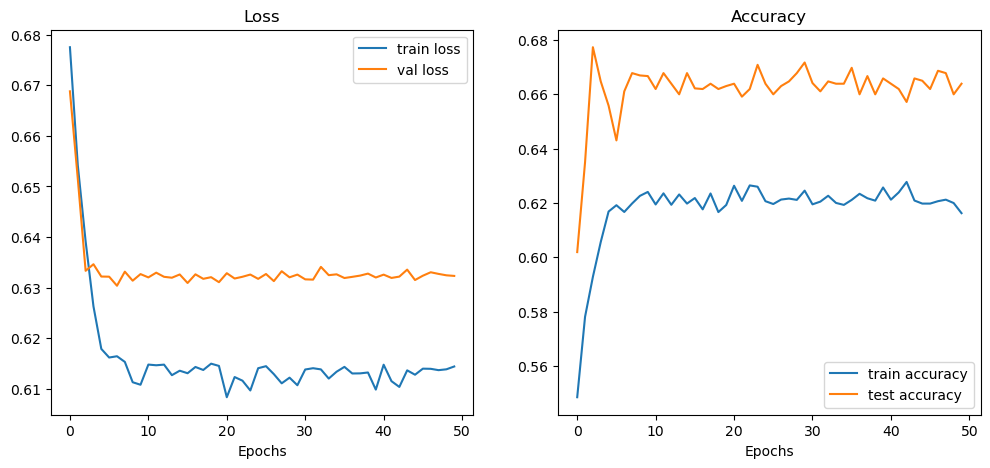

In [27]:
plot_curves(model_1_results)

#### No se observa una mejora utilizando más datos de entrenamiento. Se tendrá que hacer modificaciones en el modelo

## Segundo Modelo

### Se modifican los tamaños de las imágenes y se crean nuvos sets de entrenamiento, validación y prueba

In [54]:
new_img_size = 224

data_transform = transforms.Compose([
  transforms.Resize((new_img_size, new_img_size)),
  transforms.ToTensor()
])

In [55]:
train_dir = './images/train/'
val_dir = './images/val/'
test_dir = './images/test/'

train_data_new = datasets.ImageFolder(root=train_dir, transform=data_transform)
val_data_new = datasets.ImageFolder(root=val_dir, transform=data_transform)
test_data_new = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [56]:
class_names_new = train_data_new.classes
print(class_names_new)

class_dict_new = train_data_new.class_to_idx
print(class_dict_new)

print(len(train_data_new), len(val_data_new), len(test_data_new))

img, lab = train_data_new[0][0], train_data_new[0][1]

print('Image shape: ', img.shape)
print('Image datatype: ', img.dtype)
print('Image label: ', lab, class_names_new[lab])
print('Label datatype: ', type(lab))

['cats', 'dogs']
{'cats': 0, 'dogs': 1}
24960 489 246
Image shape:  torch.Size([3, 224, 224])
Image datatype:  torch.float32
Image label:  0 cats
Label datatype:  <class 'int'>


In [57]:
train_dataload_new = DataLoader(
  dataset=train_data_new,
  batch_size=128,
  num_workers=os.cpu_count(),
  shuffle=True
)

val_dataload_new = DataLoader(
  dataset=val_data_new,
  batch_size=128,
  num_workers=os.cpu_count(),
  shuffle=False
)

test_dataload_new = DataLoader(
  dataset=test_data_new,
  batch_size=128,
  num_workers=os.cpu_count(),
  shuffle=False
)

train_dataload_new, val_dataload_new, test_dataload_new

(<torch.utils.data.dataloader.DataLoader at 0x28e5da980>,
 <torch.utils.data.dataloader.DataLoader at 0x28e5d8250>)

In [6]:
img, label = next(iter(train_dataload_new))

print(img.shape)
print(label.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


### Se crea el segundo modelo

In [3]:
class MyModel_2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_shape, 
        out_channels=hidden_units, 
        kernel_size=5,
        stride=1,
        padding=2
      ),
      
      nn.ReLU(),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
  
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units, 
        out_channels=hidden_units*2,
        kernel_size=5,
        stride=1,
        padding=2
      ),
      nn.ReLU(),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )

    self.conv_block_3 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*4,
        kernel_size=3,
        stride=1,
        padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )


    self.classifier = nn.Sequential(
      nn.Flatten(), 
      nn.Linear(
        in_features=hidden_units*4*28*28,
        out_features=128
      ),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(
        in_features=128,
        out_features=output_shape
      )
    )

  def forward(self, x):
    
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))
    

    
    

In [7]:
device = torch.device('mps')
print(f'Using device: {device}')


Using device: mps


In [9]:
model_2 = MyModel_2(input_shape=3, hidden_units=32, output_shape=len(train_data_new.classes)).to(device)
model_2

MyModel_2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [10]:
summary(model_2, input_size=[128, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
MyModel_2                                [128, 2]                  --
├─Sequential: 1-1                        [128, 32, 112, 112]       --
│    └─Conv2d: 2-1                       [128, 32, 224, 224]       2,432
│    └─ReLU: 2-2                         [128, 32, 224, 224]       --
│    └─MaxPool2d: 2-3                    [128, 32, 112, 112]       --
├─Sequential: 1-2                        [128, 64, 56, 56]         --
│    └─Conv2d: 2-4                       [128, 64, 112, 112]       51,264
│    └─ReLU: 2-5                         [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-6                    [128, 64, 56, 56]         --
├─Sequential: 1-3                        [128, 128, 28, 28]        --
│    └─Conv2d: 2-7                       [128, 128, 56, 56]        73,856
│    └─ReLU: 2-8                         [128, 128, 56, 56]        --
│    └─MaxPool2d: 2-9                    [128, 128, 28, 28]        --
├─Se

### Se hace una prueba corta de 5 epochs para ver que corra el modelo

In [15]:
num_epochs = 5

model_2 = MyModel_2(input_shape=3, hidden_units=32, output_shape=len(train_data_new.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
lr_rate = 1e-4
optimiser = torch.optim.Adam(params=model_2.parameters(), lr=lr_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=0, threshold=1e-5, min_lr=1e-8, verbose=1)

model_2_results = train(
  model=model_2,
  train_dataloader=train_dataload_new,
  test_dataloader=val_dataload_new,
  optimiser=optimiser,
  scheduler=scheduler,
  loss_fn=loss_fn,
  epochs=num_epochs)

print('Train Finished')

 20%|██        | 1/5 [03:19<13:16, 199.06s/it]

Epoch 1
 -------- 

train loss: 0.60991, train accuracy: 0.65180 | test_loss: 0.57915, test accuracy: 0.67667


 40%|████      | 2/5 [06:39<09:59, 199.87s/it]

Epoch 2
 -------- 

train loss: 0.50942, train accuracy: 0.74211 | test_loss: 0.57685, test accuracy: 0.67528


 60%|██████    | 3/5 [10:00<06:41, 200.52s/it]

Epoch 3
 -------- 

train loss: 0.45412, train accuracy: 0.78273 | test_loss: 0.57391, test accuracy: 0.68454


 80%|████████  | 4/5 [13:24<03:21, 201.60s/it]

Epoch 4
 -------- 

train loss: 0.39784, train accuracy: 0.81546 | test_loss: 0.56945, test accuracy: 0.70011


100%|██████████| 5/5 [16:46<00:00, 201.39s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch 5
 -------- 

train loss: 0.34766, train accuracy: 0.84259 | test_loss: 0.57583, test accuracy: 0.70030
Train Finished


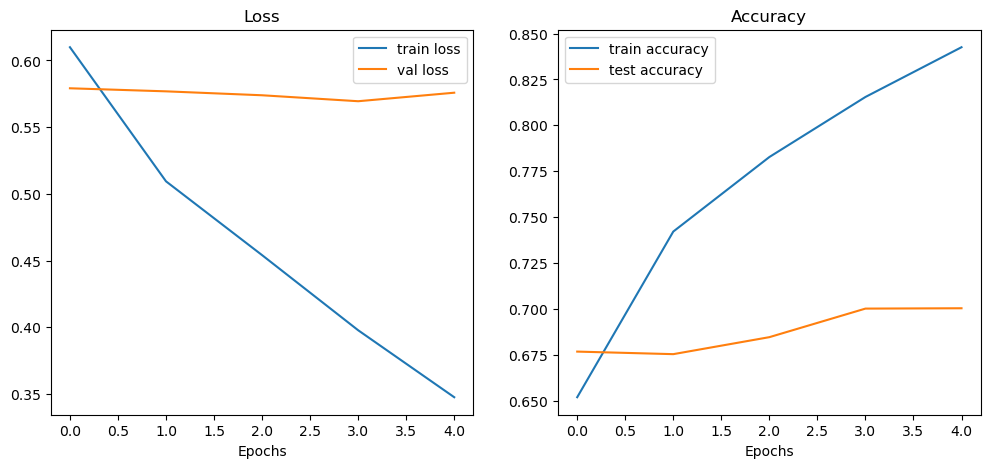

In [17]:
plot_curves(model_2_results)

#### Se observa que se mejora el modelo aún con solo cinco épocas (aunque con un poco de sobre-entrenamiento). Se entrenará por más épocas para ver si mejora este comportamiento

In [18]:
num_epochs = 50

model_2 = MyModel_2(input_shape=3, hidden_units=32, output_shape=len(train_data_new.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
lr_rate = 1e-4
optimiser = torch.optim.Adam(params=model_2.parameters(), lr=lr_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=0, threshold=1e-5, min_lr=1e-8, verbose=1)

model_2_results = train(
  model=model_2,
  train_dataloader=train_dataload_new,
  test_dataloader=val_dataload_new,
  optimiser=optimiser,
  scheduler=scheduler,
  loss_fn=loss_fn,
  epochs=num_epochs)

print('Train Finished')

  2%|▏         | 1/50 [03:21<2:44:35, 201.53s/it]

Epoch 1
 -------- 

train loss: 0.60596, train accuracy: 0.65717 | test_loss: 0.58535, test accuracy: 0.68529


  4%|▍         | 2/50 [06:42<2:40:44, 200.94s/it]

Epoch 2
 -------- 

train loss: 0.50653, train accuracy: 0.74375 | test_loss: 0.57026, test accuracy: 0.69315


  6%|▌         | 3/50 [10:00<2:36:35, 199.91s/it]

Epoch 3
 -------- 

train loss: 0.45656, train accuracy: 0.78129 | test_loss: 0.56706, test accuracy: 0.67405


  8%|▊         | 4/50 [13:21<2:33:26, 200.15s/it]

Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Epoch 4
 -------- 

train loss: 0.40531, train accuracy: 0.81034 | test_loss: 0.59570, test accuracy: 0.71012


 10%|█         | 5/50 [16:41<2:30:08, 200.18s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-06.
Epoch 5
 -------- 

train loss: 0.35531, train accuracy: 0.84151 | test_loss: 0.57262, test accuracy: 0.70982


 12%|█▏        | 6/50 [20:04<2:27:30, 201.15s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-07.
Epoch 6
 -------- 

train loss: 0.34688, train accuracy: 0.84932 | test_loss: 0.57260, test accuracy: 0.70396


 14%|█▍        | 7/50 [23:28<2:24:48, 202.07s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-08.
Epoch 7
 -------- 

train loss: 0.34607, train accuracy: 0.84784 | test_loss: 0.57196, test accuracy: 0.70006


 16%|█▌        | 8/50 [26:49<2:21:08, 201.63s/it]

Epoch 8
 -------- 

train loss: 0.34733, train accuracy: 0.84704 | test_loss: 0.57193, test accuracy: 0.70244


 18%|█▊        | 9/50 [30:07<2:17:09, 200.73s/it]

Epoch 9
 -------- 

train loss: 0.34643, train accuracy: 0.84936 | test_loss: 0.57192, test accuracy: 0.70244


 20%|██        | 10/50 [33:30<2:14:06, 201.15s/it]

Epoch 10
 -------- 

train loss: 0.34590, train accuracy: 0.84748 | test_loss: 0.57190, test accuracy: 0.70244


 22%|██▏       | 11/50 [36:50<2:10:40, 201.04s/it]

Epoch 11
 -------- 

train loss: 0.34814, train accuracy: 0.84471 | test_loss: 0.57187, test accuracy: 0.70244


 24%|██▍       | 12/50 [40:10<2:07:00, 200.54s/it]

Epoch 12
 -------- 

train loss: 0.34440, train accuracy: 0.84844 | test_loss: 0.57185, test accuracy: 0.70244


 26%|██▌       | 13/50 [43:30<2:03:38, 200.49s/it]

Epoch 13
 -------- 

train loss: 0.34566, train accuracy: 0.84756 | test_loss: 0.57184, test accuracy: 0.70244


 28%|██▊       | 14/50 [46:51<2:00:26, 200.74s/it]

Epoch 14
 -------- 

train loss: 0.34574, train accuracy: 0.84912 | test_loss: 0.57183, test accuracy: 0.70244


 30%|███       | 15/50 [50:14<1:57:22, 201.20s/it]

Epoch 15
 -------- 

train loss: 0.34587, train accuracy: 0.84704 | test_loss: 0.57182, test accuracy: 0.70244


 32%|███▏      | 16/50 [53:32<1:53:36, 200.48s/it]

Epoch 16
 -------- 

train loss: 0.34619, train accuracy: 0.84824 | test_loss: 0.57181, test accuracy: 0.70244


 34%|███▍      | 17/50 [56:50<1:49:51, 199.74s/it]

Epoch 17
 -------- 

train loss: 0.34541, train accuracy: 0.84772 | test_loss: 0.57180, test accuracy: 0.70244


 36%|███▌      | 18/50 [1:00:08<1:46:07, 199.00s/it]

Epoch 18
 -------- 

train loss: 0.34556, train accuracy: 0.84772 | test_loss: 0.57175, test accuracy: 0.70244


 38%|███▊      | 19/50 [1:03:25<1:42:33, 198.51s/it]

Epoch 19
 -------- 

train loss: 0.34512, train accuracy: 0.84860 | test_loss: 0.57177, test accuracy: 0.70244


 40%|████      | 20/50 [1:06:43<1:39:11, 198.38s/it]

Epoch 20
 -------- 

train loss: 0.34706, train accuracy: 0.84784 | test_loss: 0.57175, test accuracy: 0.70244


 42%|████▏     | 21/50 [1:10:02<1:35:54, 198.43s/it]

Epoch 21
 -------- 

train loss: 0.34387, train accuracy: 0.84980 | test_loss: 0.57176, test accuracy: 0.70244


 44%|████▍     | 22/50 [1:13:19<1:32:23, 198.00s/it]

Epoch 22
 -------- 

train loss: 0.34550, train accuracy: 0.84816 | test_loss: 0.57174, test accuracy: 0.70244


 46%|████▌     | 23/50 [1:16:36<1:29:02, 197.86s/it]

Epoch 23
 -------- 

train loss: 0.34603, train accuracy: 0.84571 | test_loss: 0.57174, test accuracy: 0.70244


 48%|████▊     | 24/50 [1:19:53<1:25:34, 197.49s/it]

Epoch 24
 -------- 

train loss: 0.34628, train accuracy: 0.84595 | test_loss: 0.57172, test accuracy: 0.70244


 50%|█████     | 25/50 [1:23:11<1:22:21, 197.66s/it]

Epoch 25
 -------- 

train loss: 0.34558, train accuracy: 0.84696 | test_loss: 0.57169, test accuracy: 0.70244


 52%|█████▏    | 26/50 [1:26:29<1:19:06, 197.79s/it]

Epoch 26
 -------- 

train loss: 0.34623, train accuracy: 0.84816 | test_loss: 0.57170, test accuracy: 0.70244


 54%|█████▍    | 27/50 [1:29:47<1:15:47, 197.71s/it]

Epoch 27
 -------- 

train loss: 0.34735, train accuracy: 0.84756 | test_loss: 0.57169, test accuracy: 0.70244


 56%|█████▌    | 28/50 [1:33:05<1:12:34, 197.93s/it]

Epoch 28
 -------- 

train loss: 0.34484, train accuracy: 0.84860 | test_loss: 0.57170, test accuracy: 0.70244


 58%|█████▊    | 29/50 [1:36:24<1:09:20, 198.10s/it]

Epoch 29
 -------- 

train loss: 0.34635, train accuracy: 0.84864 | test_loss: 0.57168, test accuracy: 0.70244


 60%|██████    | 30/50 [1:39:42<1:06:02, 198.14s/it]

Epoch 30
 -------- 

train loss: 0.34548, train accuracy: 0.84740 | test_loss: 0.57166, test accuracy: 0.70244


 62%|██████▏   | 31/50 [1:43:00<1:02:46, 198.21s/it]

Epoch 31
 -------- 

train loss: 0.34489, train accuracy: 0.84800 | test_loss: 0.57165, test accuracy: 0.70244


 64%|██████▍   | 32/50 [1:46:18<59:26, 198.15s/it]  

Epoch 32
 -------- 

train loss: 0.34706, train accuracy: 0.84760 | test_loss: 0.57164, test accuracy: 0.70244


 66%|██████▌   | 33/50 [1:49:36<56:08, 198.13s/it]

Epoch 33
 -------- 

train loss: 0.34639, train accuracy: 0.84744 | test_loss: 0.57161, test accuracy: 0.70439


 68%|██████▊   | 34/50 [1:52:55<52:52, 198.25s/it]

Epoch 34
 -------- 

train loss: 0.34578, train accuracy: 0.84736 | test_loss: 0.57159, test accuracy: 0.70439


 70%|███████   | 35/50 [1:56:14<49:37, 198.47s/it]

Epoch 35
 -------- 

train loss: 0.34667, train accuracy: 0.84667 | test_loss: 0.57158, test accuracy: 0.70439


 72%|███████▏  | 36/50 [1:59:32<46:18, 198.49s/it]

Epoch 36
 -------- 

train loss: 0.34409, train accuracy: 0.84816 | test_loss: 0.57159, test accuracy: 0.70439


 74%|███████▍  | 37/50 [2:02:50<42:59, 198.39s/it]

Epoch 37
 -------- 

train loss: 0.34635, train accuracy: 0.84924 | test_loss: 0.57161, test accuracy: 0.70439


 76%|███████▌  | 38/50 [2:06:09<39:39, 198.30s/it]

Epoch 38
 -------- 

train loss: 0.34439, train accuracy: 0.84872 | test_loss: 0.57161, test accuracy: 0.70439


 78%|███████▊  | 39/50 [2:09:28<36:24, 198.55s/it]

Epoch 39
 -------- 

train loss: 0.34533, train accuracy: 0.84728 | test_loss: 0.57161, test accuracy: 0.70439


 80%|████████  | 40/50 [2:12:46<33:05, 198.51s/it]

Epoch 40
 -------- 

train loss: 0.34680, train accuracy: 0.84728 | test_loss: 0.57162, test accuracy: 0.70439


 82%|████████▏ | 41/50 [2:16:08<29:54, 199.44s/it]

Epoch 41
 -------- 

train loss: 0.34599, train accuracy: 0.84844 | test_loss: 0.57162, test accuracy: 0.70439


 84%|████████▍ | 42/50 [2:19:26<26:34, 199.25s/it]

Epoch 42
 -------- 

train loss: 0.34547, train accuracy: 0.84896 | test_loss: 0.57163, test accuracy: 0.70439


 86%|████████▌ | 43/50 [2:22:45<23:12, 198.96s/it]

Epoch 43
 -------- 

train loss: 0.34472, train accuracy: 0.84968 | test_loss: 0.57161, test accuracy: 0.70439


 88%|████████▊ | 44/50 [2:26:03<19:53, 198.85s/it]

Epoch 44
 -------- 

train loss: 0.34373, train accuracy: 0.84840 | test_loss: 0.57162, test accuracy: 0.70439


 90%|█████████ | 45/50 [2:29:21<16:32, 198.60s/it]

Epoch 45
 -------- 

train loss: 0.34642, train accuracy: 0.84744 | test_loss: 0.57161, test accuracy: 0.70439


 92%|█████████▏| 46/50 [2:32:40<13:14, 198.54s/it]

Epoch 46
 -------- 

train loss: 0.34592, train accuracy: 0.84876 | test_loss: 0.57161, test accuracy: 0.70439


 94%|█████████▍| 47/50 [2:35:59<09:56, 198.70s/it]

Epoch 47
 -------- 

train loss: 0.34502, train accuracy: 0.84868 | test_loss: 0.57160, test accuracy: 0.70439


 96%|█████████▌| 48/50 [2:39:18<06:37, 198.72s/it]

Epoch 48
 -------- 

train loss: 0.34549, train accuracy: 0.84860 | test_loss: 0.57160, test accuracy: 0.70439


 98%|█████████▊| 49/50 [2:42:37<03:19, 199.01s/it]

Epoch 49
 -------- 

train loss: 0.34512, train accuracy: 0.84876 | test_loss: 0.57159, test accuracy: 0.70439


100%|██████████| 50/50 [2:45:56<00:00, 199.14s/it]

Epoch 50
 -------- 

train loss: 0.34614, train accuracy: 0.84880 | test_loss: 0.57158, test accuracy: 0.70439
Train Finished


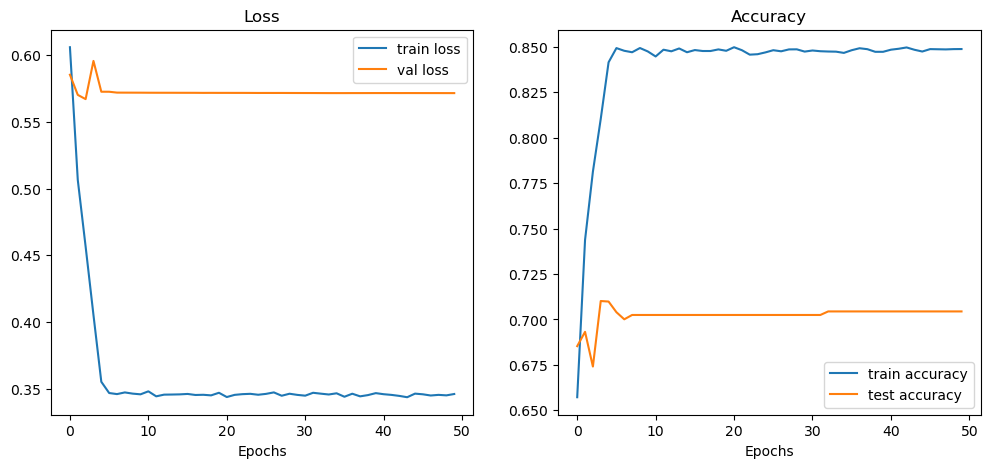

In [19]:
plot_curves(model_2_results)

#### Se observa un sobreentrenamiento, aunque este es mínimo considerando las escalas de las gráficas. Por otro lado, se observa que las pérdidas no son muy grandes, pero el entrenamiento en más épocas no ayuda a contrarestar el sobreentrenamiento. En el mismo orden de ideas, se observa que los modelos arrojan pérdidas y precisión sin modificación importante alrededor de la época ocho (siete en la gráfica)

## Prueba del modelo
  - Dado que se ha alcanzado el requisito mínimo de precisión (accuracy) de 70%, se realizan pruebas del modelo con imágenes que no ha visto previamente

#### Se guarda el modelo para no perder los pesos ni la información del mismo

In [21]:
list(model_2.named_parameters())

/Users/alejandrodelgado/new_pytorch/new_pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


[('conv_block_1.0.weight',
  Parameter containing:
  tensor([[[[ 5.5936e-03,  1.0021e-01, -4.3754e-02, -5.4475e-03, -1.0803e-01],
            [ 9.7350e-02, -6.9045e-02, -1.0742e-02, -6.6764e-03,  3.2842e-02],
            [ 9.0421e-02,  6.3331e-02, -7.4440e-02, -9.7581e-03,  1.0749e-01],
            [ 1.0702e-01,  3.4990e-02, -9.3563e-02, -1.2620e-02,  6.2188e-02],
            [ 2.7141e-02, -7.1827e-02,  1.1731e-02,  3.2836e-02, -7.5873e-02]],
  
           [[-4.9751e-02, -5.2531e-02, -8.2153e-02, -7.1025e-02, -2.7129e-02],
            [-4.9020e-02, -7.9863e-02,  6.7025e-02,  1.0582e-01, -1.0254e-02],
            [ 3.8191e-02,  9.1171e-02,  4.1933e-02,  1.0071e-01, -8.5327e-02],
            [-4.9828e-02,  1.0889e-01,  6.1333e-02,  6.8302e-02, -1.1694e-01],
            [ 1.0471e-01,  6.4856e-02,  4.6908e-02,  1.7606e-02, -1.4195e-02]],
  
           [[-8.9579e-02, -8.6115e-02, -1.1664e-01, -1.0658e-01, -4.4246e-02],
            [ 6.8595e-02,  9.0143e-02, -3.8007e-02,  1.6819e-02,  6.2899

#### Se revisan los pesos del modelo original

In [24]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 5.5936e-03,  1.0021e-01, -4.3754e-02, -5.4475e-03, -1.0803e-01],
                        [ 9.7350e-02, -6.9045e-02, -1.0742e-02, -6.6764e-03,  3.2842e-02],
                        [ 9.0421e-02,  6.3331e-02, -7.4440e-02, -9.7581e-03,  1.0749e-01],
                        [ 1.0702e-01,  3.4990e-02, -9.3563e-02, -1.2620e-02,  6.2188e-02],
                        [ 2.7141e-02, -7.1827e-02,  1.1731e-02,  3.2836e-02, -7.5873e-02]],
              
                       [[-4.9751e-02, -5.2531e-02, -8.2153e-02, -7.1025e-02, -2.7129e-02],
                        [-4.9020e-02, -7.9863e-02,  6.7025e-02,  1.0582e-01, -1.0254e-02],
                        [ 3.8191e-02,  9.1171e-02,  4.1933e-02,  1.0071e-01, -8.5327e-02],
                        [-4.9828e-02,  1.0889e-01,  6.1333e-02,  6.8302e-02, -1.1694e-01],
                        [ 1.0471e-01,  6.4856e-02,  4.6908e-02,  1.7606e-02, -1.4195e-02]],
              
                   

#### Se genera un directorio donde guardar el modelo y los pesos del mismo

In [32]:
os.makedirs('./model/')
torch.save(model_2.state_dict(), './model/model_2_dict.pt')
torch.save(model_2, './model/model_2_full.pt')

#### Se carga el modelo en una nueva variable

In [75]:
new_model = torch.load('./model/model_2_full.pt')


#### Se revisa que el modelo haya sido cargado correctamente con la función de summary de torchinfo

In [5]:
summary(new_model, input_size=[128, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
MyModel_2                                [128, 2]                  --
├─Sequential: 1-1                        [128, 32, 112, 112]       --
│    └─Conv2d: 2-1                       [128, 32, 224, 224]       2,432
│    └─ReLU: 2-2                         [128, 32, 224, 224]       --
│    └─MaxPool2d: 2-3                    [128, 32, 112, 112]       --
├─Sequential: 1-2                        [128, 64, 56, 56]         --
│    └─Conv2d: 2-4                       [128, 64, 112, 112]       51,264
│    └─ReLU: 2-5                         [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-6                    [128, 64, 56, 56]         --
├─Sequential: 1-3                        [128, 128, 28, 28]        --
│    └─Conv2d: 2-7                       [128, 128, 56, 56]        73,856
│    └─ReLU: 2-8                         [128, 128, 56, 56]        --
│    └─MaxPool2d: 2-9                    [128, 128, 28, 28]        --
├─Se

### Matriz de Confusión y Reporte de Clasificación

#### Utilizando el modelo cargado (new_model), se realizan las predicciones con el set de prueba (test_dataload_new)

In [78]:
y_preds = []

new_model.eval()
with torch.inference_mode():
  for x, y in tqdm(test_dataload_new, colour='cyan', desc='Predicting values...'):
    x, y = x.to(device), y.to(device)

    y_logit = new_model(x)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

Predicting values...: 100%|██████████| 2/2 [00:12<00:00,  6.37s/it]


#### Se guardan las predicciones como un tensor

In [108]:
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0])

#### Se extraen las etiquetas de objetivos del set de prueba creado con ImageFolder y se guardan como tensor

In [109]:
targets = torch.tensor(test_data_new.targets)
targets

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

#### Utilizando la función ConfusionMatrix de torchmetrics se generan los valores y predicciones del modelo para graficarlos posteriormente con la función plot_confusion_matrix de mlxtend

In [110]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#### Se especifican los parametros para la matriz de clasificación
matrix = ConfusionMatrix(num_classes=len(class_names_new), task='binary')

### Se especifica el tensor para poder graficar la matriz de confusión
matrix_tensor = matrix(preds=y_preds_tensor, target=targets)

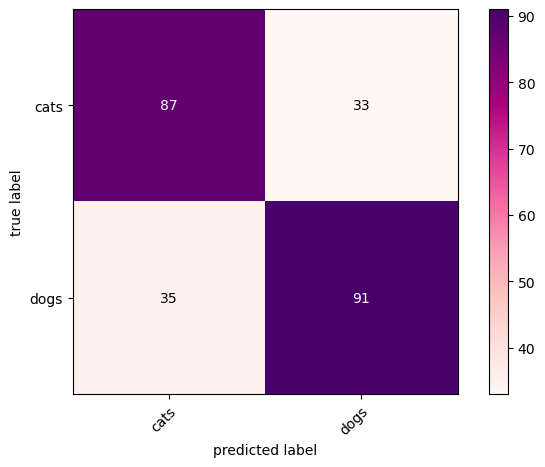

In [113]:
fig, ax = plot_confusion_matrix(conf_mat=matrix_tensor.numpy(), class_names=class_names_new, figsize=(8,5), show_absolute=True, colorbar=True, cmap='RdPu')

#### Para poder visualizar las métricas de evaluación de los modelos de clasificación, se utiliza la librería sklearn (scikit-learn), en específico la función de classification_report

In [115]:
from sklearn.metrics import classification_report

print(classification_report(
  y_true=targets.data.numpy(), # se pasan los valores reales a numpy para poder utilizarlos en sklearn
  y_pred=y_preds_tensor.data.numpy(), # se pasan los valores de predicción a numpy para poder utilizarlso en sklearn
  target_names=class_names_new # se indican las clases para mostrar en el reporte de clasificación
  )
)

              precision    recall  f1-score   support

        cats       0.71      0.72      0.72       120
        dogs       0.73      0.72      0.73       126

    accuracy                           0.72       246
   macro avg       0.72      0.72      0.72       246
weighted avg       0.72      0.72      0.72       246



## Conclusiones
  - Utilizando el set de prueba, se observa que la precisión sigue siendo aproximadamente la misma que con el set de validación durante el entrenamiento del modelo

  - El recall se puede considerar un valor "medio" dado que tiene una tendencia a clasificar de manera correcta que falsos negativos

  - En resumen, el modelo tiene una tendencia a clasificar de manera correcta si las imágenes que se le pasan son de gatos (cats) o perros (dogs). Aún así, hay espacio para poder mejorar el modelo